#  Imports

In [2]:
#!pip install selenium
#!pip install webdriver-manager

import requests as rq
import pandas as pd
from bs4 import BeautifulSoup as bs
import numpy as np
import time 
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait

In [3]:
import sklearn
from sklearn import linear_model, metrics, preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, f1_score

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# --------cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# -------- classification
import sklearn
from sklearn import neighbors, tree, ensemble, naive_bayes, svm
# *** KNN
from sklearn.neighbors import KNeighborsClassifier
# *** Decision Tree; Random Forest
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# *** Naive Bayes
from sklearn.naive_bayes import GaussianNB
# *** SVM classifier
from sklearn.svm import SVC
# --------  metrics:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import make_scorer

In [4]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline


# Functions

In [ ]:
def clickNextPage():
    nextpage = driver.find_elements(by=By.XPATH, value ='//html/body/main/div[2]/div[2]/div[2]/div[2]/nav/ul/li[13]/a')
    action = webdriver.common.action_chains.ActionChains(driver)
    action.move_to_element_with_offset(nextpage[0], 10,10)
    action.click()
    action.perform()
    time.sleep(0.15)

In [ ]:
def clickOnRows():
    time.sleep(0.15)
    for row in driver.find_elements(by=By.XPATH, value='//tbody/tr'):
        row.click()
        time.sleep(0.15)


In [ ]:
def updateUrl():
    html= driver.page_source
    soup=bs(html, 'html.parser')
    table = soup("table",attrs={"class":"table"})[0]          
    xpand_table = table("td",attrs={"colspan":"9"}) 
    return table,xpand_table
    

In [9]:
def findIndexInList(lst,pattern):
    for element in lst:
        if element.text.find(pattern) != -1:
            return lst.index(element)
    return -1
        
    

In [10]:
def findIndexInStringList(lst,pattern):
    for element in lst:
        if element.find(pattern) != -1:
            return lst.index(element)
    return -1

In [11]:
def AddDistrict(df):
    citiesDf=pd.read_csv('cities_dist.csv')
    citiesList = list(citiesDf["שם יישוב"])
    distList = list(citiesDf["מחוז"])

    district = []

    for city in df["city"]:
        index = findIndexInStringList(citiesList,city)
        if index !=-1:
            district.append(distList[index])
        else:
            district.append(np.nan)

    df["district"] = district
    return df

In [12]:
def DataRef(df):
    df[df.columns] = df[df.columns].astype(object)
    df=df.dropna(subset=['price'])
    df.price = df.price.str.replace(',', '').astype(float).astype(int)
    df = df.replace(to_replace='', value=np.nan)
    df.loc[(df["price_per_sqm"].isnull()),"price_per_sqm"]= "-1"
    
    df["parking"] = df["parking"].replace(to_replace=' ', value="")
    df[['parkings','string']] = df["parking"].str.split("ר", expand = True)
    
    df.drop(columns=['parking','string'],inplace=True)
    df.loc[(df["parkings"].isnull()),"parkings"]= -55
    df['parkings'] = df['parkings'].astype(int)
    
    df=df.drop_duplicates()
    
    df = df.drop_duplicates(subset=['date','city','address','rooms','space','price','build_year','prop_type'])
    #build year
    df = df.drop_duplicates(subset=['date','city','address','rooms','space','price','prop_type'])
    #space
    df = df.drop_duplicates(subset=['date','city','address','rooms','price','prop_type'])
    #rooms
    df = df.drop_duplicates(subset=['date','city','address','price','prop_type'])
    
    df = df.drop_duplicates(subset=['city','rooms','space','price','build_year','prop_type','date'])
    
    df[["day", "month", "year"]] = df["date"].str.split("/", expand = True).astype(int)
    df.drop(columns=['day','date'],inplace=True)
    df.loc[df["address"].isnull(),'address'] = "ללא רחוב"
    df=df.dropna(subset=['rooms'])
    df=df.dropna(subset=['city'])
    df=df.dropna(subset=['space'])
    df["has_yard"] = np.where(df["yard"].notnull(), 1, 0)
    df.loc[(df["prop_type"]=="קוטג' דו משפחתי") | (df["prop_type"]=="דירת גן") | (df["prop_type"]=="קוטג' חד משפחתי") |
           (df["prop_type"]=="קוטג' טורי"),'has_yard'] = 1
    df.loc[(df["prop_type"]=="קוטג' דו משפחתי") | (df["prop_type"]=="דירת גן") | (df["prop_type"]=="קוטג' חד משפחתי")
            | (df["prop_type"]=="בית בודד") | (df["prop_type"]=="קוטג' טורי"), 'floor'] = 1
    
    
    df = df[df["prop_type"] != "אופציה"]
    df = df[df["prop_type"] != "במשק חקלאי-נחלה"]
    
    
    df.loc[(df["floor"].isnull()),"floor"]= -55
    df['rooms'] = df['rooms'].astype(int)
    df['space'] = df['space'].astype(int)
    df['floor'] = df['floor'].astype(int)
    df['build_year'] = df['build_year'].astype(int)
    df=df.drop(columns=['yard','apartment'])
    
    df.loc[(df["parkings"]==-55 ),"parkings"]= np.nan
    
    df.loc[(df["floor"]==-55),"floor"]= np.nan
    
    df.loc[(df["floor"]>1),"has_yard"] = 0
    
    df['price_per_sqm']=df['price_per_sqm'].str.replace(',', '').astype(float).astype(int)
    for index, row in df[df["price_per_sqm"]==-1].iterrows():
        df["price_per_sqm"][index] = df["price"][index]/df["space"][index]
    
    
    df.loc[(df["price_per_sqm"]==-1),"price_per_sqm"]= np.nan
    
    return df

In [ ]:
def createList(date,city,address,rooms,space,floor,price,price_per_sqm,build_year,apartment,prop_type,parking,yard):
    
    table,xpand_table=updateUrl()
    
    len_og=len(date)
    len_xpand=len(prop_type)
    print("---------------------------------------------------------------------------")
    print("len og:" ,len(date),len(city),len(address),len(rooms),len(space),len(floor),len(price),len(price_per_sqm),len(build_year))
    print("len xpand: ",len(apartment),len(prop_type),len(parking),len(yard))
   
    list_attrs=['דירה','מהות','חצר','חניה'] 
    
    run=1
    
    while(run):
        for rows in table("tr"):
            cells=rows("td")
            if(len(cells)<9):
                continue
            date.append(cells[0].get_text().strip())
            city.append(cells[1].get_text().strip())
            address.append(cells[2].get_text().strip())
            rooms.append(cells[3].get_text().strip())
            space.append(cells[4].get_text().strip())
            floor.append(cells[5].get_text().strip())
            price.append(cells[6].get_text().strip())
            price_per_sqm.append(cells[7].get_text().strip())
            build_year.append(cells[8].get_text().strip())

        for i in range(50):
            try:
                xpand_table[i]
            except:
                print(i)
                break
            else:
                listdts = xpand_table[i].find_all('dt')
                listdds = xpand_table[i].find_all('dd')
                for attr in list_attrs:
                    value = findIndexInList(listdts, attr)
                    if attr=='דירה':
                        if value != -1:
                            apartment.append(listdds[value].text.strip())
                        else:
                            apartment.append(np.nan)
                    if attr=='מהות':
                        if value != -1:
                            prop_type.append(listdds[value].text.strip())
                        else:
                            prop_type.append(np.nan)
                    if attr=='חצר':
                        if value != -1:
                            yard.append(listdds[value].text.strip())
                        else:
                            yard.append(np.nan)
                    if attr=='חניה':
                        if value != -1:
                            parking.append(listdds[value].text.strip())
                        else:
                            parking.append(np.nan)

        print(len(date),"VS",len(prop_type))
        if(len(date)==len(prop_type)):
            print("finished page")
            run=0
        
        if(len(date)!=len(prop_type)):
            print("len doesnt match")
            print("len og before while:" ,len(date),len(city),len(address),len(rooms),len(space),len(floor),len(price),len(price_per_sqm),len(build_year))
            print("len xpand before while:",len(apartment),len(prop_type),len(parking),len(yard))
            date = date[:len_og]
            city= city[:len_og]
            address= address[:len_og]
            rooms= rooms[:len_og]
            space= space[:len_og]
            floor= floor[:len_og]
            price= price[:len_og]
            price_per_sqm= price_per_sqm[:len_og]
            build_year= build_year[:len_og]
            apartment= apartment[:len_og]
            prop_type= prop_type[:len_og]
            parking= parking[:len_og]
            yard= yard[:len_og]
            driver.refresh()
            time.sleep(2)
            clickOnRows()
            table,xpand_table=updateUrl()
            print("len og after while:" ,len(date),len(city),len(address),len(rooms),len(space),len(floor),len(price),len(price_per_sqm),len(build_year))
            print("len xpand after while: ",len(apartment),len(prop_type),len(parking),len(yard))
    
    return date,city,address,rooms,space,floor,price,price_per_sqm,build_year,apartment,prop_type,parking,yard

            


In [5]:
def split_to_train_and_test(dataset, label_column, test_ratio, rand_state):
    
    train_rows = dataset.columns[dataset.columns != label_column]
    test_rows = label_column

    X = dataset[train_rows].copy()
    X.drop(columns = ['address'], inplace=True)
    y = dataset[test_rows]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rand_state, test_size=test_ratio)
    
    return X_train, X_test, y_train, y_test


# Main

In [ ]:
#selenium initialization
options=webdriver.ChromeOptions()
path_to_extension = r'C:\Users\matan\Desktop\לימודים\שנה ב\מדעי הנתונים\final project\1.46.0_0'
options.add_argument('load-extension=' + path_to_extension)
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
url='https://www.ad.co.il/nadlanprice'


In [ ]:
date = []
city = []
address = []
rooms = []
space = []
floor = []
price = []
price_per_sqm = []
build_year = []
apartment = []
prop_type=[]
parking=[]
yard=[]


driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)
driver.get(url)



for i in range(120):
    while (1):
        try:
            clickOnRows()
        except:
            print(f"failed on page {i}")
            driver.refresh()
            continue
        else:
            date,city,address,rooms,space,floor,price,price_per_sqm,build_year,apartment,prop_type,parking,yard = 
            createList(date,city,address,rooms,space,floor,price,price_per_sqm,build_year,apartment,prop_type,parking,yard)
            clickNextPage()
            break



In [ ]:
df=pd.DataFrame({"date":date,"city":city,"address":address,"rooms":rooms,"space":space,"floor":floor,"price":price,
                 "price_per_sqm":price_per_sqm,"build_year":build_year,"apartment" : apartment,"prop_type": prop_type,
                  "parking": parking, "yard": yard})

df.to_csv("DataFrame.csv", encoding="utf-8-sig")

In [6]:
df = pd.read_csv("TotalDataFrame.csv")
df.drop(columns = ["Unnamed: 0","Unnamed: 0.1"], inplace = True)

In [7]:
df

,date,city,address,rooms,space,floor,price,price_per_sqm,build_year,apartment,prop_type,parking,yard
0,28/01/2021,ירושלים,רמת מוצא 27,5.0,134.0,1.0,"3,675,000","27,425",2000.0,1,קוטג' חד משפחתי,1 רכבים,152.0
1,28/01/2021,גבעתיים,המבוא 9,2.0,72.0,3.0,"1,961,800","27,247",1960.0,7,דירה בבית קומות,0 רכבים,NaN
2,28/01/2021,ירושלים,רמת מוצא 27,5.0,134.0,NaN,"3,675,000","27,425",2000.0,NaN,קוטג' חד משפחתי,NaN,NaN
3,28/01/2021,גבעתיים,המרי 26,2.0,72.0,NaN,"1,961,800","27,247",1960.0,NaN,דירה בבית קומות,NaN,NaN
4,27/01/2021,אור עקיבא,אור עקיבא 3,5.0,120.0,8.0,"1,665,000","13,875",2017.0,39,דירה בבית קומות,2 רכבים,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440687,02/7/2015,ראשון לציון,הירשפלד 11,4.0,87.0,2.0,"1,500,000","17,241",1974.0,NaN,דירה בבית קומות,NaN,NaN
440688,02/7/2015,אשקלון,פקיעין 6,4.0,113.0,4.0,"1,100,000","9,734",1998.0,41,דירה בבית קומות,NaN,NaN
440689,02/7/2015,אשקלון,מגידו 8,4.0,78.0,2.0,"960,000","12,307",2002.0,8,דירה בבית קומות,NaN,NaN
440690,02/7/2015,אשדוד,שפירא אברהם 5,3.0,61.0,4.0,"810,000","13,278",1971.0,16,דירה בבית קומות,NaN,NaN


### Clean up

In [13]:
df = DataRef(df)
df

C:\Users\bonik\AppData\Local\Temp\ipykernel_11908\1041159991.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.price = df.price.str.replace(',', '').astype(float).astype(int)
C:\Users\bonik\AppData\Local\Temp\ipykernel_11908\1041159991.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price_per_sqm"][index] = df["price"][index]/df["space"][index]


,city,address,rooms,space,floor,price,price_per_sqm,build_year,prop_type,parkings,month,year,has_yard
0,ירושלים,רמת מוצא 27,5,134,1.0,3675000,27425.0,2000,קוטג' חד משפחתי,1.0,1,2021,1
1,גבעתיים,המבוא 9,2,72,3.0,1961800,27247.0,1960,דירה בבית קומות,0.0,1,2021,0
4,אור עקיבא,אור עקיבא 3,5,120,8.0,1665000,13875.0,2017,דירה בבית קומות,2.0,1,2021,0
5,אופקים,אופקים - ללא רחוב 34,5,187,1.0,1850000,9893.0,2019,קוטג' חד משפחתי,0.0,1,2021,1
6,חולון,זבוטינסקי 6,3,70,2.0,1445000,20642.0,1960,דירה בבית קומות,0.0,1,2021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
440687,ראשון לציון,הירשפלד 11,4,87,2.0,1500000,17241.0,1974,דירה בבית קומות,NaN,7,2015,0
440688,אשקלון,פקיעין 6,4,113,4.0,1100000,9734.0,1998,דירה בבית קומות,NaN,7,2015,0
440689,אשקלון,מגידו 8,4,78,2.0,960000,12307.0,2002,דירה בבית קומות,NaN,7,2015,0
440690,אשדוד,שפירא אברהם 5,3,61,4.0,810000,13278.0,1971,דירה בבית קומות,NaN,7,2015,0


In [14]:
df = AddDistrict(df)
df

,city,address,rooms,space,floor,price,price_per_sqm,build_year,prop_type,parkings,month,year,has_yard,district
0,ירושלים,רמת מוצא 27,5,134,1.0,3675000,27425.0,2000,קוטג' חד משפחתי,1.0,1,2021,1,Jerusalem
1,גבעתיים,המבוא 9,2,72,3.0,1961800,27247.0,1960,דירה בבית קומות,0.0,1,2021,0,Tel Aviv
4,אור עקיבא,אור עקיבא 3,5,120,8.0,1665000,13875.0,2017,דירה בבית קומות,2.0,1,2021,0,Haifa
5,אופקים,אופקים - ללא רחוב 34,5,187,1.0,1850000,9893.0,2019,קוטג' חד משפחתי,0.0,1,2021,1,Southern
6,חולון,זבוטינסקי 6,3,70,2.0,1445000,20642.0,1960,דירה בבית קומות,0.0,1,2021,0,Tel Aviv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440687,ראשון לציון,הירשפלד 11,4,87,2.0,1500000,17241.0,1974,דירה בבית קומות,NaN,7,2015,0,Central
440688,אשקלון,פקיעין 6,4,113,4.0,1100000,9734.0,1998,דירה בבית קומות,NaN,7,2015,0,Southern
440689,אשקלון,מגידו 8,4,78,2.0,960000,12307.0,2002,דירה בבית קומות,NaN,7,2015,0,Southern
440690,אשדוד,שפירא אברהם 5,3,61,4.0,810000,13278.0,1971,דירה בבית קומות,NaN,7,2015,0,Southern


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 211861 entries, 0 to 440691
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   city           211861 non-null  object 
 1   address        211861 non-null  object 
 2   rooms          211861 non-null  int32  
 3   space          211861 non-null  int32  
 4   floor          180563 non-null  float64
 5   price          211861 non-null  int32  
 6   price_per_sqm  211861 non-null  float64
 7   build_year     211861 non-null  int32  
 8   prop_type      211861 non-null  object 
 9   parkings       165646 non-null  float64
 10  month          211861 non-null  int32  
 11  year           211861 non-null  int32  
 12  has_yard       211861 non-null  int32  
 13  district       211861 non-null  object 
dtypes: float64(3), int32(7), object(4)
memory usage: 26.7+ MB


### Graphs

On the graphs below we can see the distribution of deals per district and per room number:

Text(0.5, 1.0, 'Percentage of Deals Per Room Number')

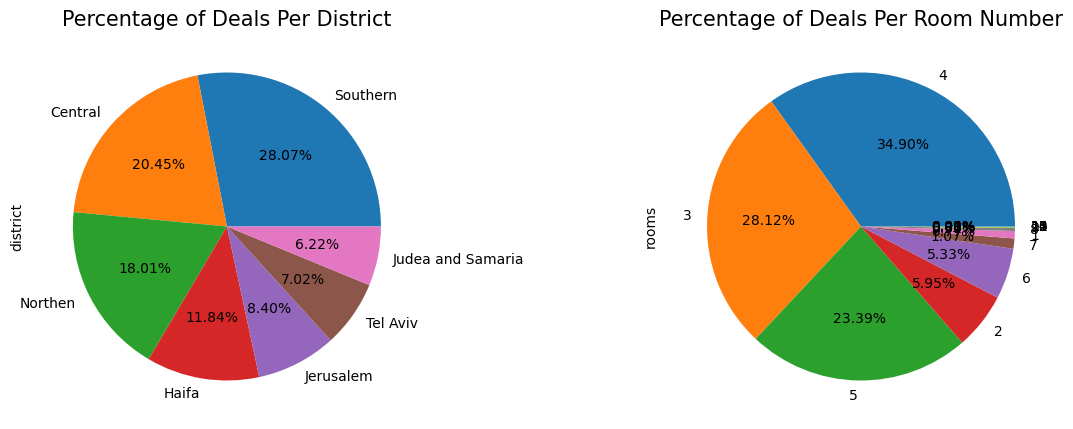

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
df["district"].value_counts().plot(kind = "pie", autopct='%.2f%%', ax = axes[0])
axes[0].set_title("Percentage of Deals Per District", size  = 15)

df["rooms"].value_counts().plot(kind = "pie", autopct='%.2f%%', ax = axes[1])
axes[1].set_title("Percentage of Deals Per Room Number", size  = 15)


In this graph, we see the average price of an apartment throughout the years

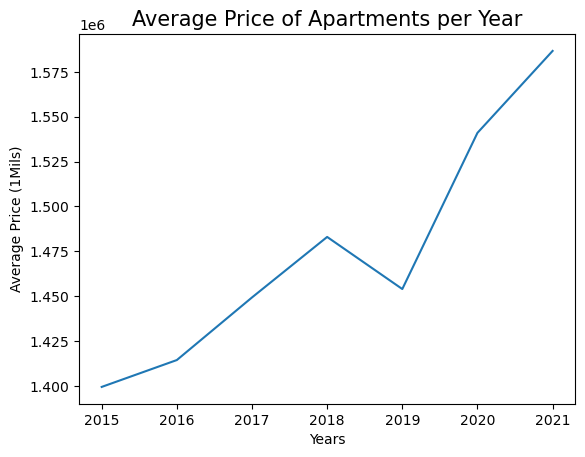

In [16]:
avg_price = df.groupby("year")["price"].mean().reset_index()
plt.plot(avg_price["year"],avg_price["price"])
plt.xlabel("Years")
plt.ylabel("Average Price (1Mils)")
plt.title("Average Price of Apartments per Year", size = 15)
plt.show()

let's see what effects the price of an apartment the most:

Text(0.5, 1.0, 'Correlations Heatmap')

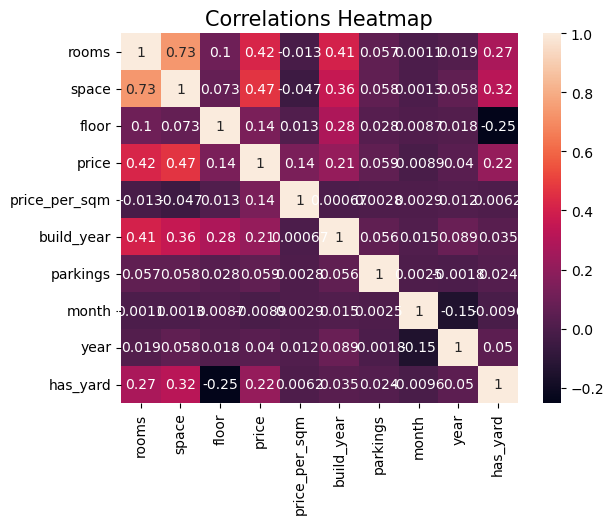

In [17]:
graph = pd.DataFrame(df, columns = df.columns)
sns.heatmap(graph.corr(), annot = True)
plt.title("Correlations Heatmap", size = 15)

we can see that the space and rooms have the strongest effect on the price of the apartment.
we can also see that those parameters are strongly correlataed.
the 3rd and 4th most impactful paramets are 'has_yard' and 'build_year'

In [19]:
colors = np.array(["indianred", "black", "darkorange", "mediumseagreen", "slateblue", "maroon", "olive", "crimson",
          "teal", "chocolate", "fuchsia", "indigo", 'silver', "navajowhite", 'lime', 'royalblue'])
roomslist = df['rooms'].sort_values().unique()
yearslist = df['year'].sort_values().unique()

Text(0, 0.5, 'Price (10Mil)')

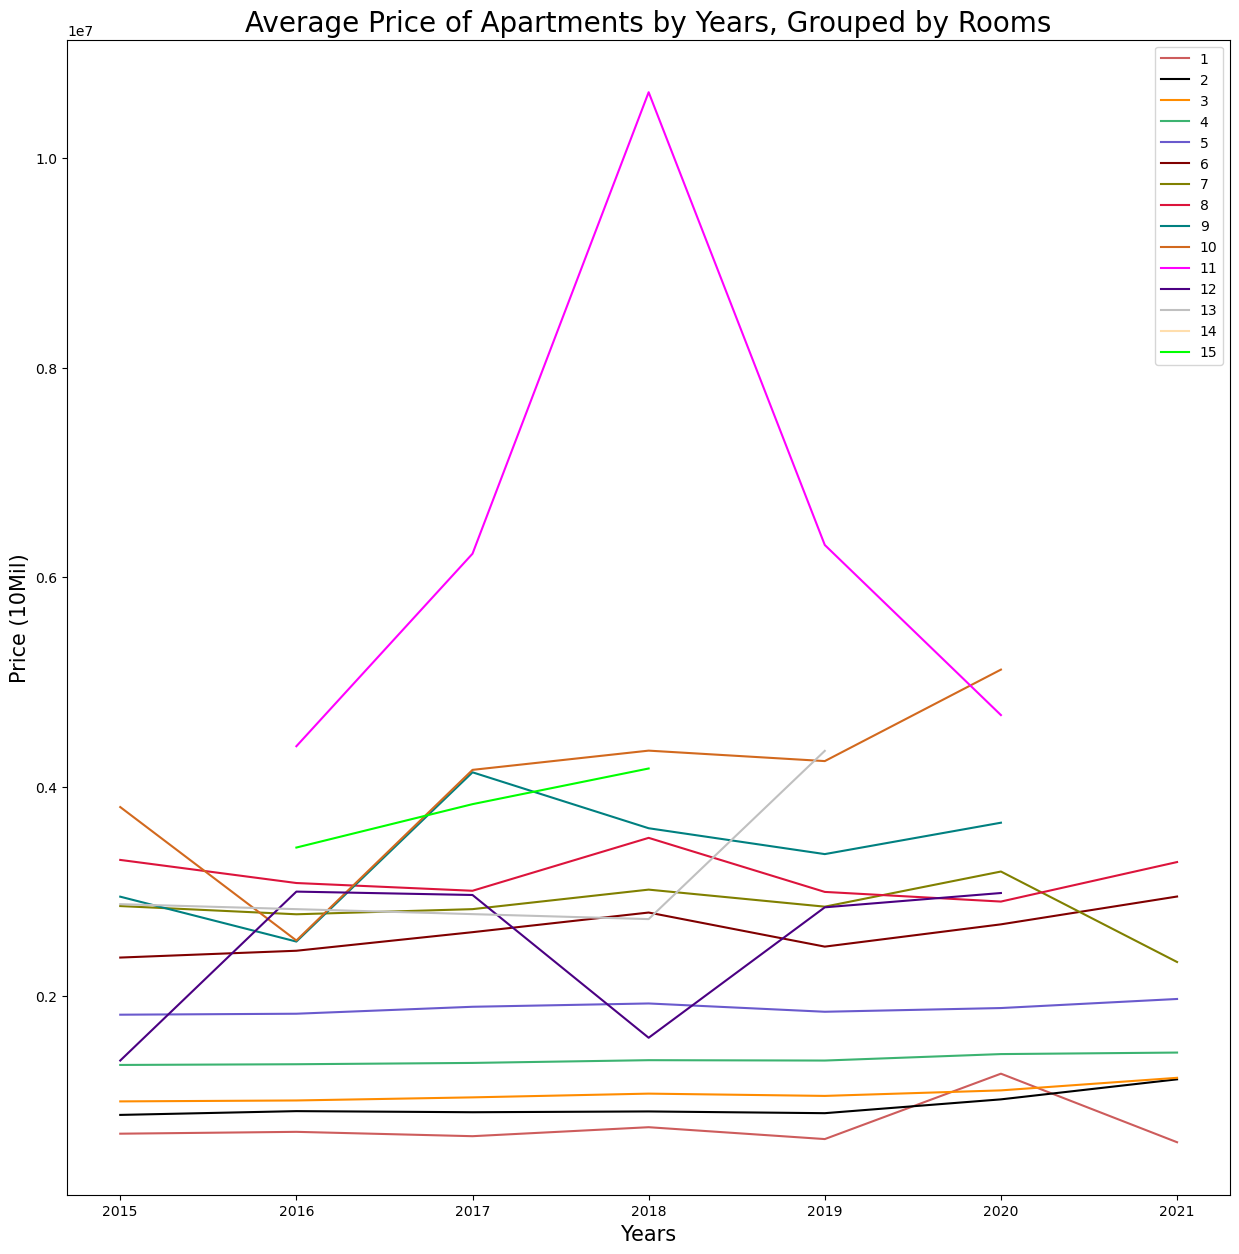

In [20]:


for i in range(len(roomslist)):
    df[df["rooms"] == roomslist[i]].groupby(["year"])['price'].mean().plot(kind = "line",legend=True, label = str(roomslist[i]) , color = colors[i], figsize = (15,15))

plt.title("Average Price of Apartments by Years, Grouped by Rooms", size = 20)
plt.xlabel("Years", size = 15)
plt.ylabel("Price (10Mil)", size = 15)



a bit overwhelming, isn't it?

let's split to subplots:

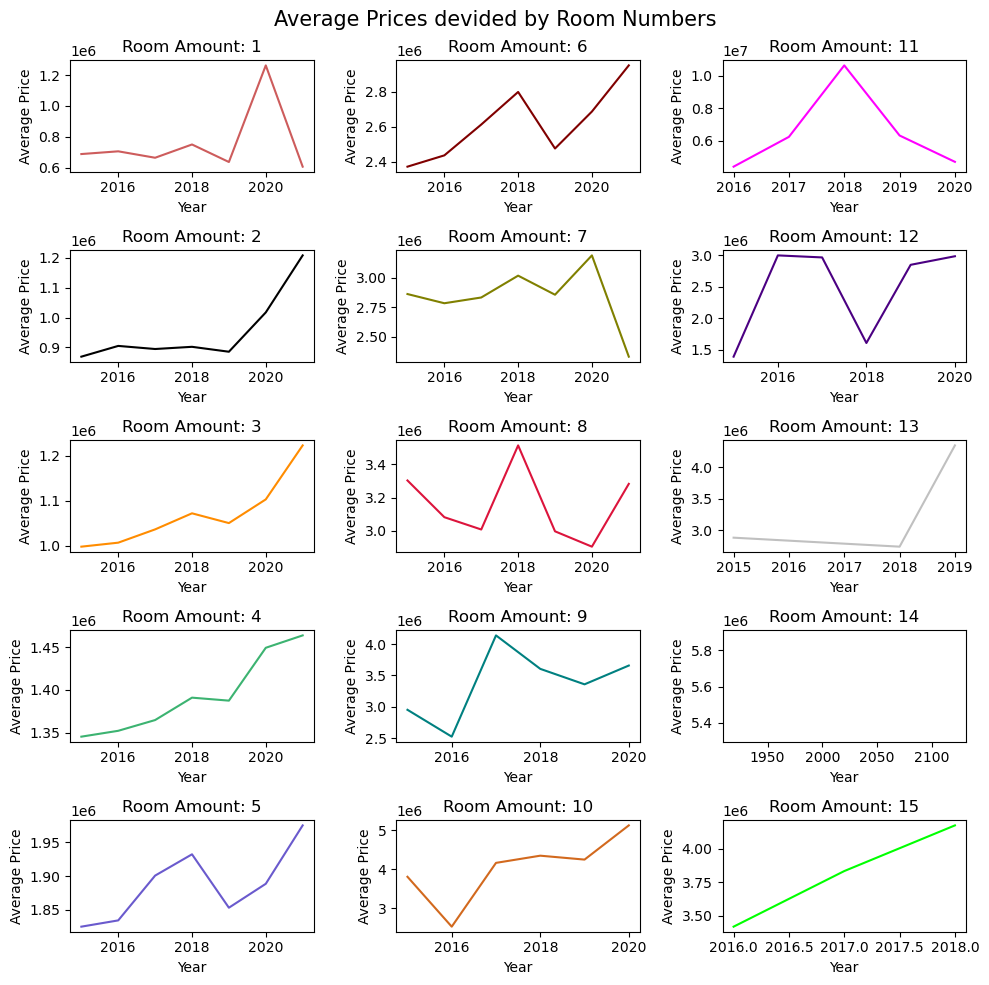

In [24]:
groups = df.groupby(["rooms", "year"])
avg_price = groups["price"].mean().reset_index()
groups = avg_price.groupby("rooms")
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,10))
fig.suptitle("Average Prices devided by Room Numbers", size = 15)


for i, (name, group) in enumerate(groups):
    ax = axes[i%5][int(i/5)]
    ax.plot(group["year"], group["price"], color = colors[i])
    ax.set_title("Room Amount: {}".format(name))
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Price")

plt.tight_layout()
plt.show()

let's spare you the messy graph for devision by districts and skip to subplots:

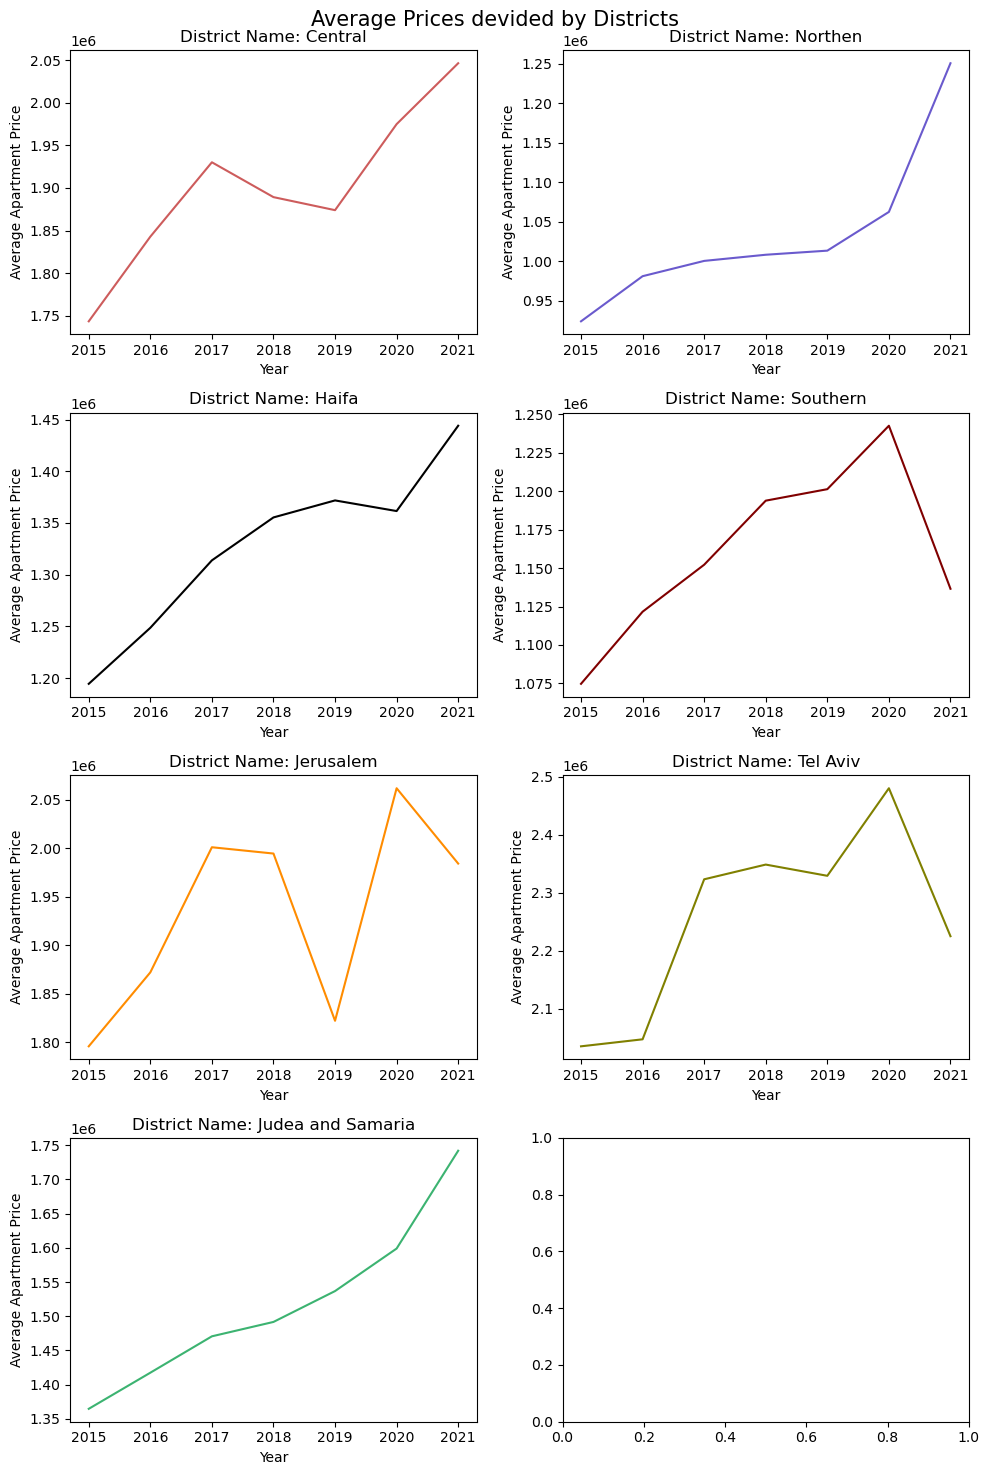

In [25]:
groups = df.groupby(["year", "district"])
avg_price = groups["price"].mean().reset_index()
groups = avg_price.groupby("district")
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,15))

fig.suptitle("Average Prices devided by Districts", size = 15)   
for i, (name, group) in enumerate(groups):
    ax = axes[i%4][int(i/4)]
    ax.plot(group["year"], group["price"], color = colors[i])
    ax.set_title("District Name: {}".format(name))
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Apartment Price")
    
    
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Average Price of Room Numbers Over the Years')

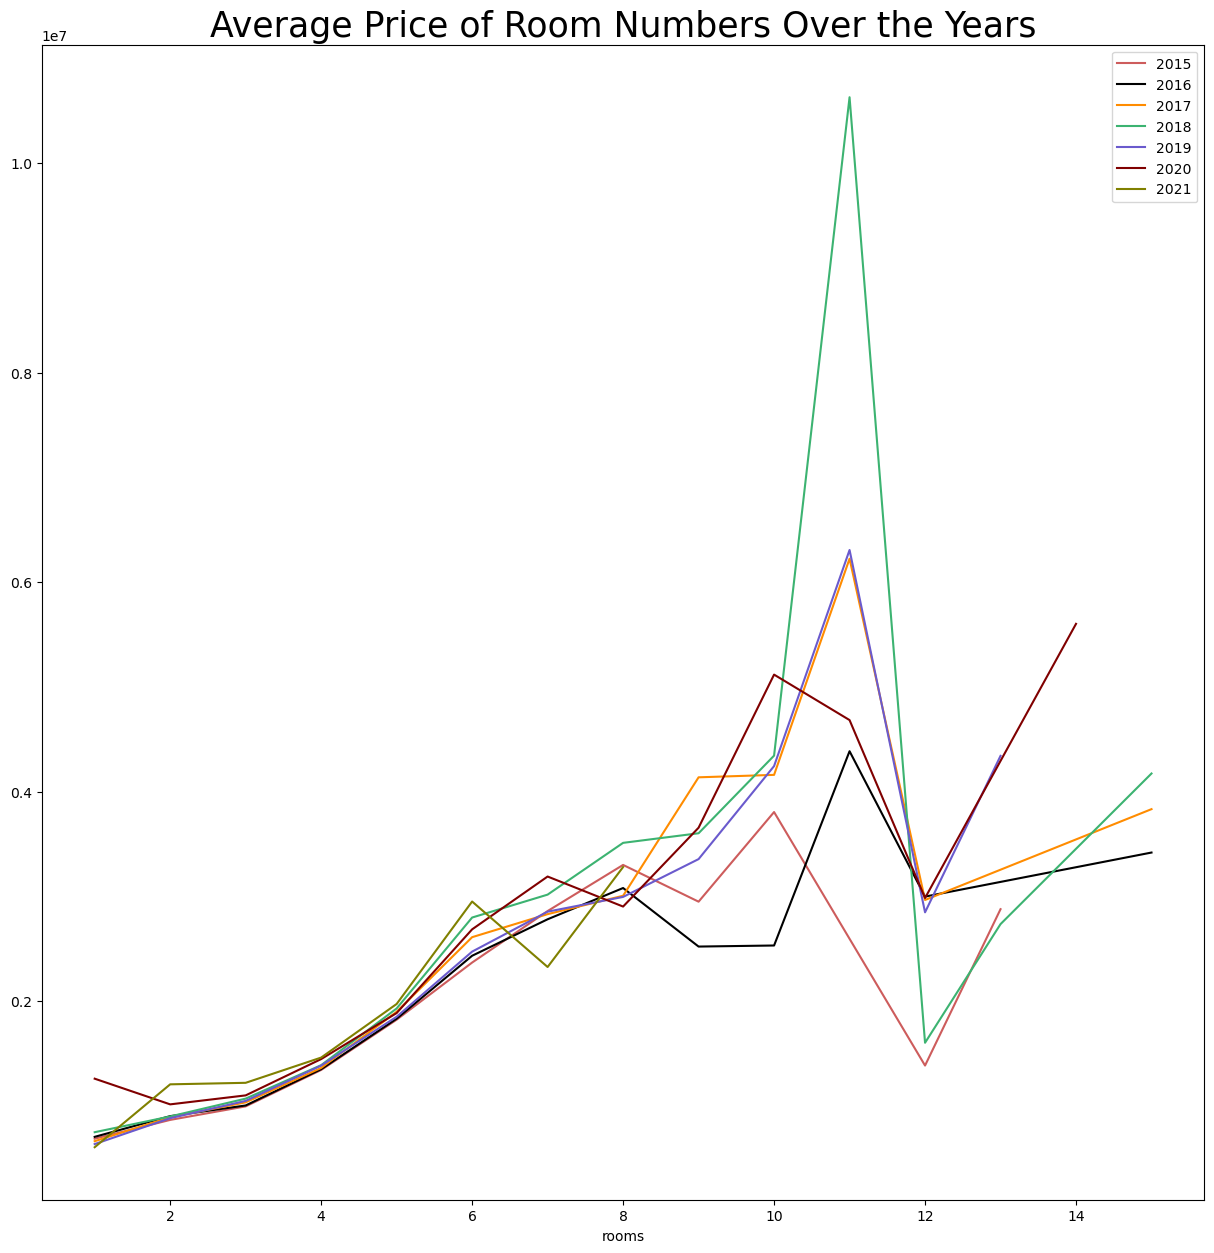

In [26]:
for i in range(len(yearslist)):
    df[df["year"] == yearslist[i]].groupby(["rooms"])['price'].mean().plot(kind = "line",legend=True, label = str(yearslist[i]) , color = colors[i], figsize = (15,15))

plt.title("Average Price of Room Numbers Over the Years", size = 25)


a bit messy, but above we can see that for the frequent room values (3,4,5,6) they mostly behave the same over the years (price wise)

Text(0, 0.5, 'Price (1Mil)')

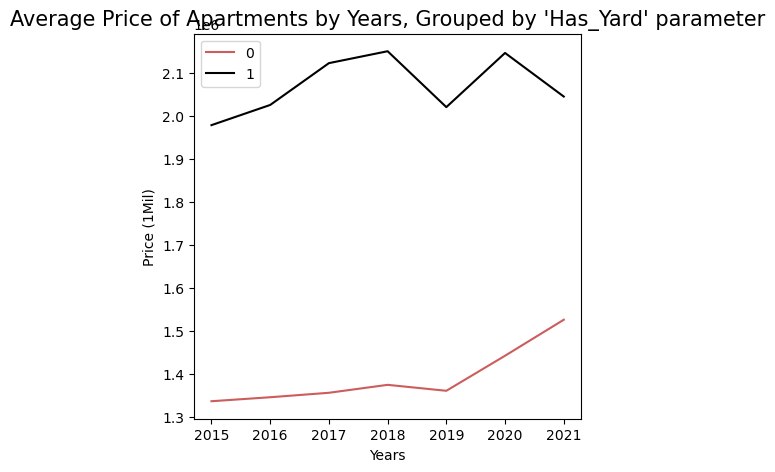

In [27]:
for i in (0,1):
    df[df["has_yard"] == i].groupby(["year"])['price'].mean().plot(kind = "line",legend=True, label = str(i) , color = colors[i], figsize = (5,5))

plt.title("Average Price of Apartments by Years, Grouped by 'Has_Yard' parameter", size = 15)
plt.xlabel("Years", size = 10)
plt.ylabel("Price (1Mil)", size = 10)

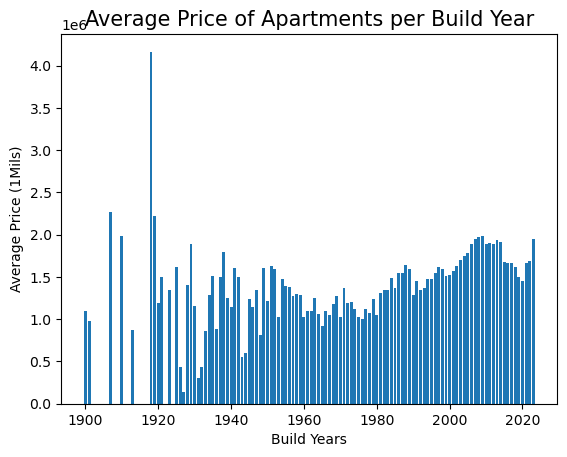

In [28]:
avg_price = df.groupby("build_year")["price"].mean().reset_index()
plt.bar(x=avg_price["build_year"], height =avg_price["price"])
plt.xlabel("Build Years")
plt.ylabel("Average Price (1Mils)")
plt.title("Average Price of Apartments per Build Year", size = 15)
plt.show()

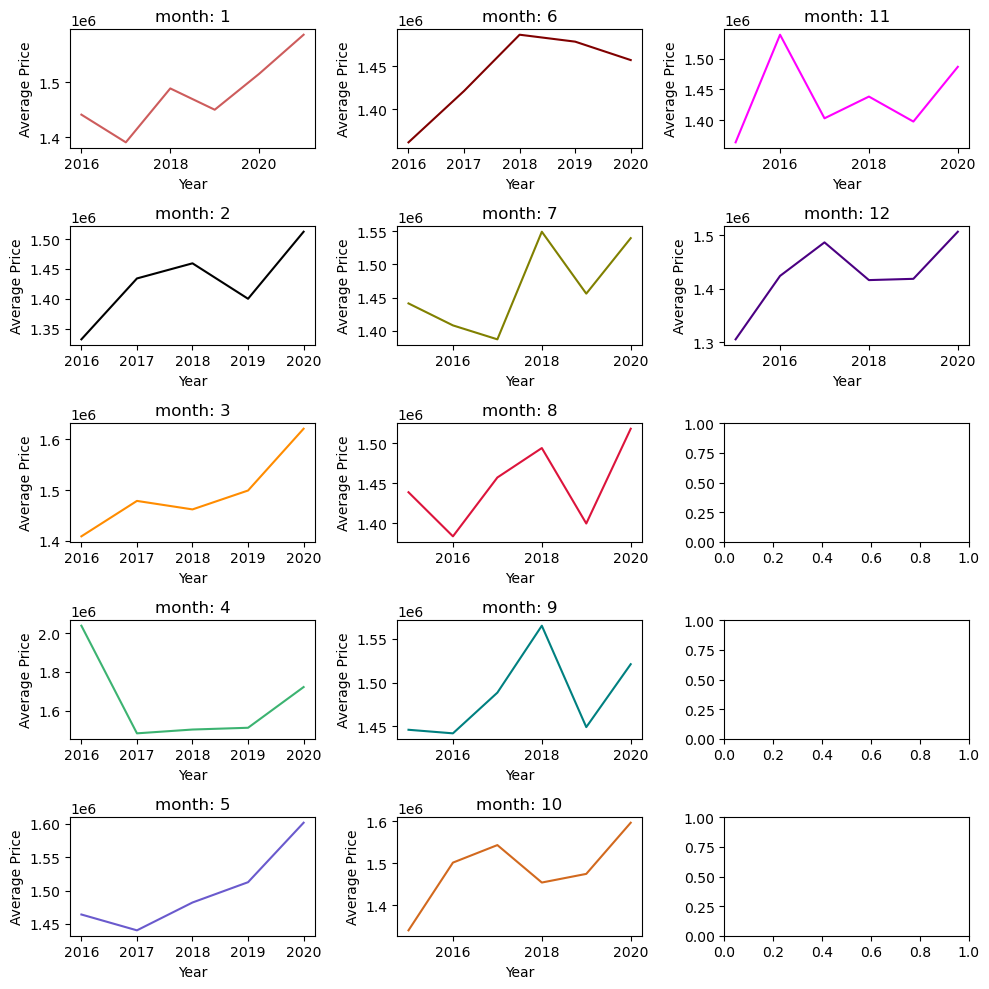

In [29]:

groups = df.groupby(["year", "month"])
avg_price = groups["price"].mean().reset_index()
groups = avg_price.groupby('month')
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,10))

for i, (name, group) in enumerate(groups):
    ax = axes[i%5][int(i/5)]
    ax.plot(group["year"], group["price"], color = colors[i])
    ax.set_title("month: {}".format(name))
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Price")

plt.tight_layout()
plt.show()

by deviding the average price over the years to months, we can see that only in june, the average price of an apartment decreases in the last couple years, but don't hold as accountable

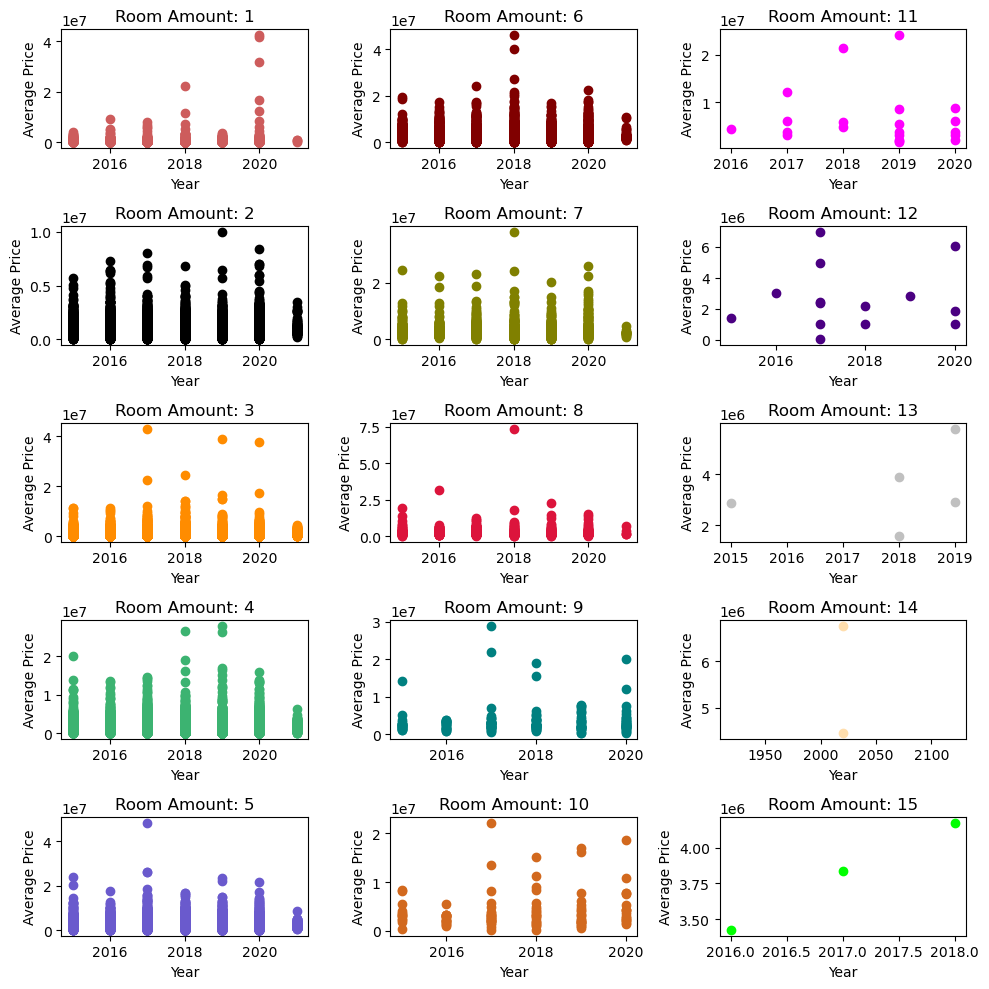

In [30]:
###### graphs we tried but not very informative
groups = df.groupby(["rooms"])
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,10))
for i, (name, group) in enumerate(groups):
    ax = axes[i%5][int(i/5)]
    ax.scatter(group["year"], group["price"], color = colors[i])
    ax.set_title("Room Amount: {}".format(name))
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Price")

plt.tight_layout()
plt.show()

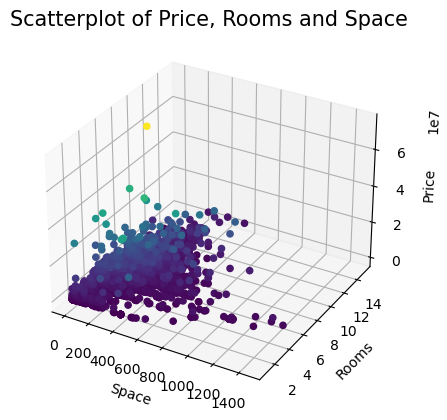

In [31]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection = "3d")

xdata = df.space
ydata = df.rooms
zdata = df.price

ax.set_xlabel("Space")
ax.set_ylabel("Rooms") 
ax.set_zlabel("Price") 

plt.title("Scatterplot of Price, Rooms and Space", size = 15)

ax.scatter3D(xdata,ydata,zdata,c=zdata,depthshade=False)

<AxesSubplot:>

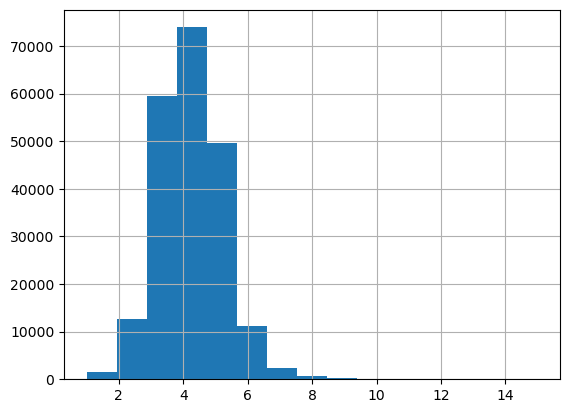

In [32]:
df.rooms.hist(bins=15)

### Ouliers handling

Text(0.5, 1.0, 'Histogram of Space, Devided to 150 Bins')

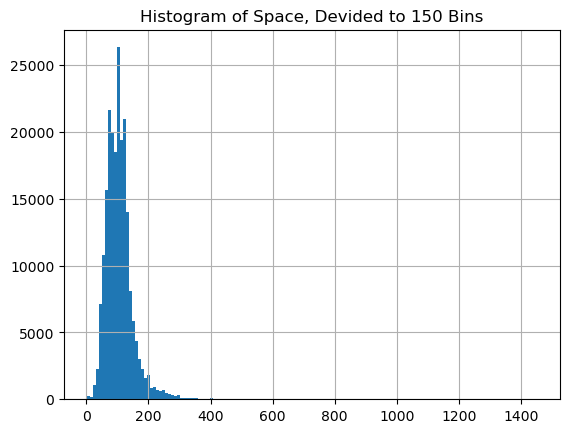

In [28]:
df.space.hist(bins = 150)
plt.title("Histogram of Space, Devided to 150 Bins")

In [34]:
print(df.space.min())
print(df.space.max())

1
1453


we can see that we have some values that exceed even 1400 square meters. they are probably outliers. it's handeling time!

Text(0.5, 1.0, 'Histogram of Prices, Devided to 200 Bins')

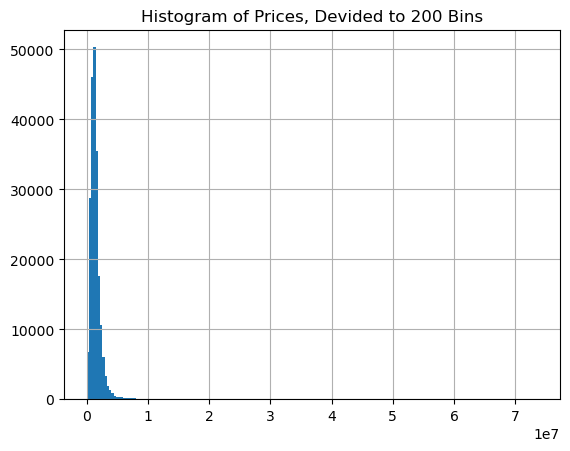

In [27]:
df.price.hist(bins=200)
plt.title("Histogram of Prices, Devided to 200 Bins")

In [35]:
df.price.max()

73636363

C:\Users\bonik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Boxplot of Rooms and Prices')

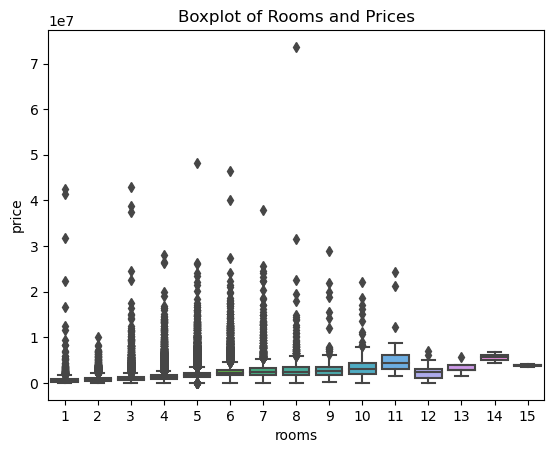

In [36]:
sns.boxplot(df["rooms"], df["price"])
plt.title("Boxplot of Rooms and Prices")

C:\Users\bonik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Boxplot of Rooms and Space')

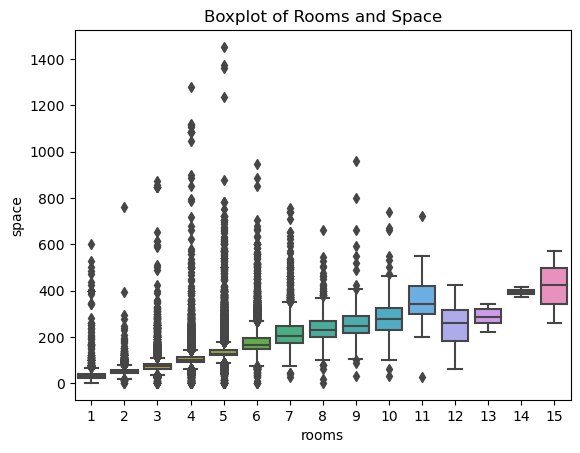

In [37]:
sns.boxplot(df["rooms"], df["space"])
plt.title("Boxplot of Rooms and Space")

in our opinion, not so many outliers in apartments with over 9 rooms because there is not enough data on sales like these because they are very rare

C:\Users\bonik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Boxplot of Space')

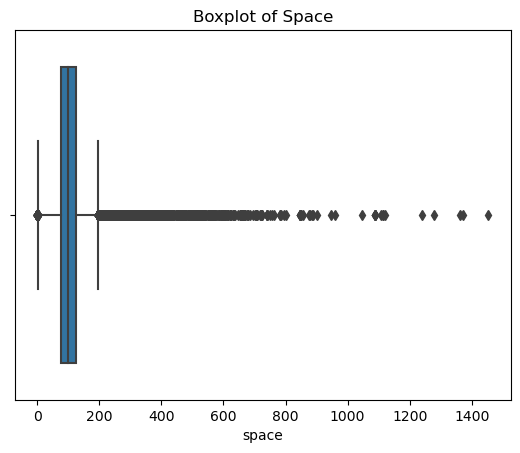

In [38]:
####### not informative enough
sns.boxplot(df["space"])
plt.title("Boxplot of Space")

In [34]:
##############clean up

from the pie chart of room numbers, we can see that over 7 rooms and 1 room are negligible parts of the data so we remove it:

In [16]:
(df[(df["rooms"]>7) | (df["rooms"]==1)].shape[0] / df.shape[0])*100

1.240435946210015

In [17]:
df = df[(df["rooms"]<=7) & (df["rooms"]>=2)]

C:\Users\bonik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rooms', ylabel='space'>

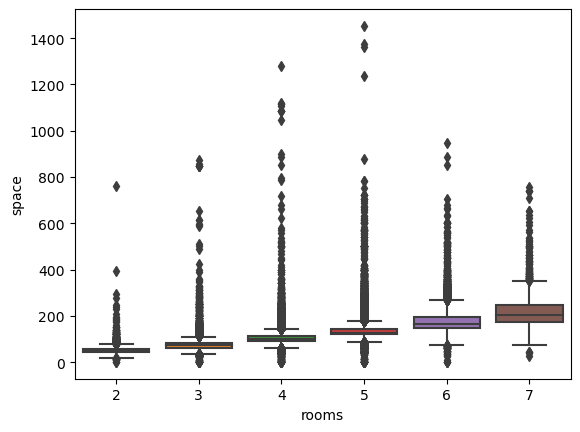

In [18]:
sns.boxplot(df["rooms"], df["space"])

In [19]:
(df[(df["space"]<20)].shape[0] / df.shape[0])*100

0.0649993069926828

In [20]:
(df[(df["space"]>400)].shape[0] / df.shape[0])*100

0.1386014634402795

In [21]:
df = df[(df["space"]>=20) & (df["space"]<=400)]

Text(0.5, 1.0, 'Histogram of Space, Devided to 150 Bins (after data cleaning)')

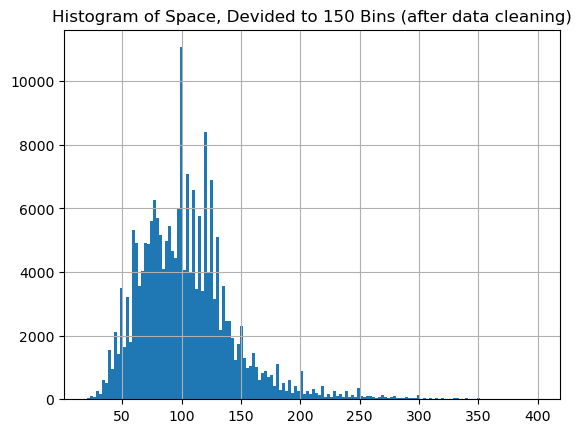

In [22]:
#after removing outliers in space column
df.space.hist(bins=150)
plt.title("Histogram of Space, Devided to 150 Bins (after data cleaning)")

In [23]:
(df[(df["price"]>10000000)].shape[0] / df.shape[0])*100

0.15037810035104188

In [24]:
df = df[(df["price"]<=10000000)]

Text(0.5, 1.0, 'Histogram of Prices, Devided to 200 Bins (after data cleaning)')

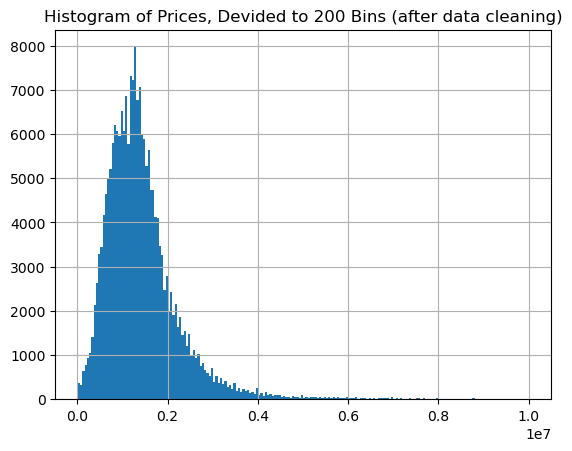

In [25]:
#after removing outliers in price column
df.price.hist(bins=200)
plt.title("Histogram of Prices, Devided to 200 Bins (after data cleaning)")

In [26]:
(df[(df["build_year"]<1920)].shape[0] / df.shape[0])*100

0.5434235202141079

In [27]:
df = df[(df["build_year"]>1920)]

### Visualization after outlier handling

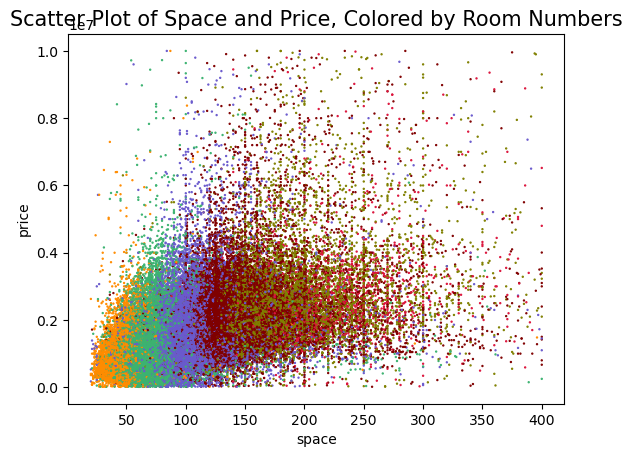

In [52]:

fig = plt.figure()
ax = plt.axes()

ax.scatter(df.space, df.price, c = colors[df.rooms], s = 0.5)

ax.set_title("Scatter Plot of Space and Price, Colored by Room Numbers", size = 15)
ax.set_xlabel("space")
ax.set_ylabel("price")

plt.show()

Text(0.5, 1.0, 'Percentage of Deals Per Room Number (after data cleaning)')

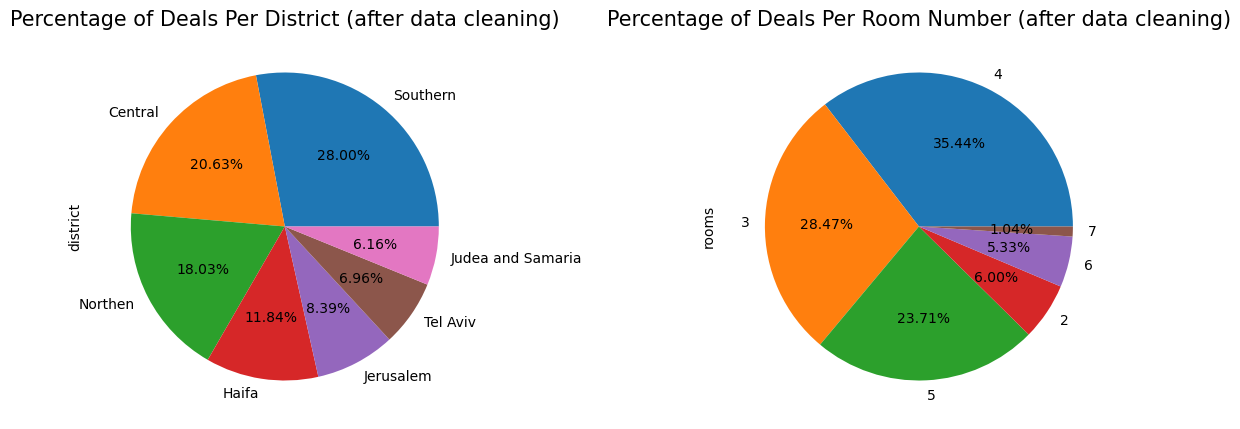

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    
df["district"].value_counts().plot(kind = "pie", autopct='%.2f%%', ax = axes[0])
axes[0].set_title("Percentage of Deals Per District (after data cleaning)", size  = 15)

df["rooms"].value_counts().plot(kind = "pie", autopct='%.2f%%', ax = axes[1])
axes[1].set_title("Percentage of Deals Per Room Number (after data cleaning)", size  = 15)


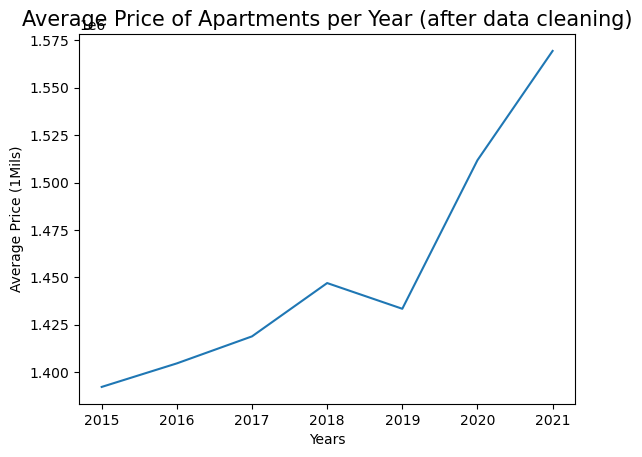

In [54]:
avg_price = df.groupby("year")["price"].mean().reset_index()
plt.plot(avg_price["year"],avg_price["price"])
plt.xlabel("Years")
plt.ylabel("Average Price (1Mils)")
plt.title("Average Price of Apartments per Year (after data cleaning)", size = 15)
plt.show()

Text(0.5, 1.0, 'Correlations Heatmap (after data cleaning)')

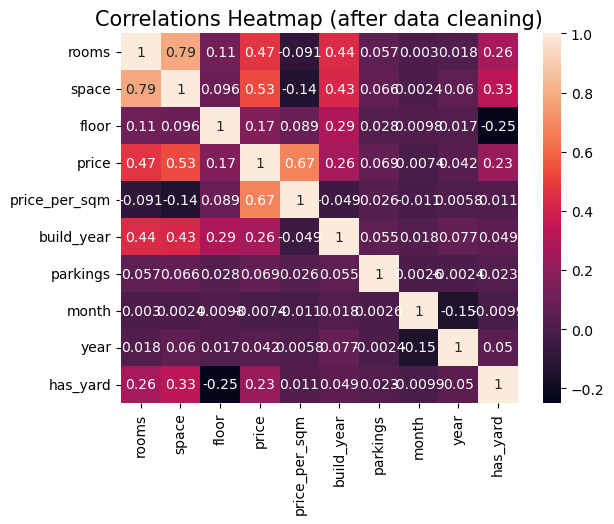

In [55]:
graph = pd.DataFrame(df, columns = df.columns)
sns.heatmap(graph.corr(), annot = True)
plt.title("Correlations Heatmap (after data cleaning)", size = 15)

In [58]:

roomslist = df['rooms'].sort_values().unique()
yearslist = df['year'].sort_values().unique()

Text(0, 0.5, 'Price (1Mil)')

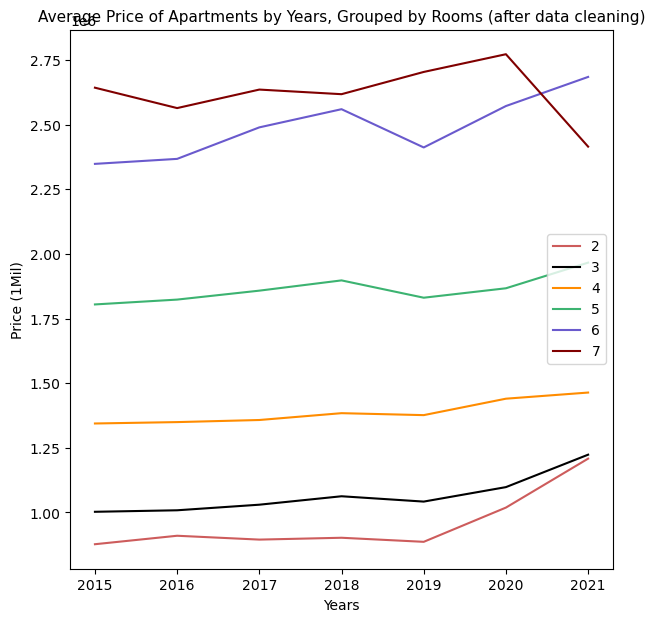

In [57]:
for i in range(len(roomslist)):
    df[df["rooms"] == roomslist[i]].groupby(["year"])['price'].mean().plot(kind = "line",legend=True, label = str(roomslist[i]) , color = colors[i], figsize = (7,7))

plt.title("Average Price of Apartments by Years, Grouped by Rooms (after data cleaning)", size = 11)
plt.xlabel("Years", size = 10)
plt.ylabel("Price (1Mil)", size = 10)

looks better already :)

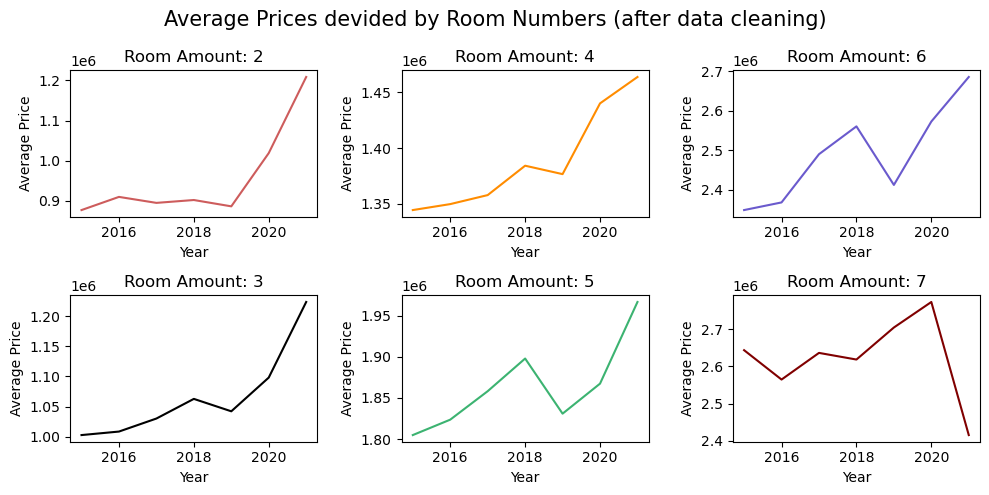

In [59]:
groups = df.groupby(["rooms", "year"])
avg_price = groups["price"].mean().reset_index()
groups = avg_price.groupby("rooms")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))
fig.suptitle("Average Prices devided by Room Numbers (after data cleaning)", size = 15)

for i, (name, group) in enumerate(groups):
    ax = axes[i%2][int(i/2)]
    ax.plot(group["year"], group["price"], color = colors[i])
    ax.set_title("Room Amount: {}".format(name))
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Price")
    
plt.tight_layout()
plt.show()

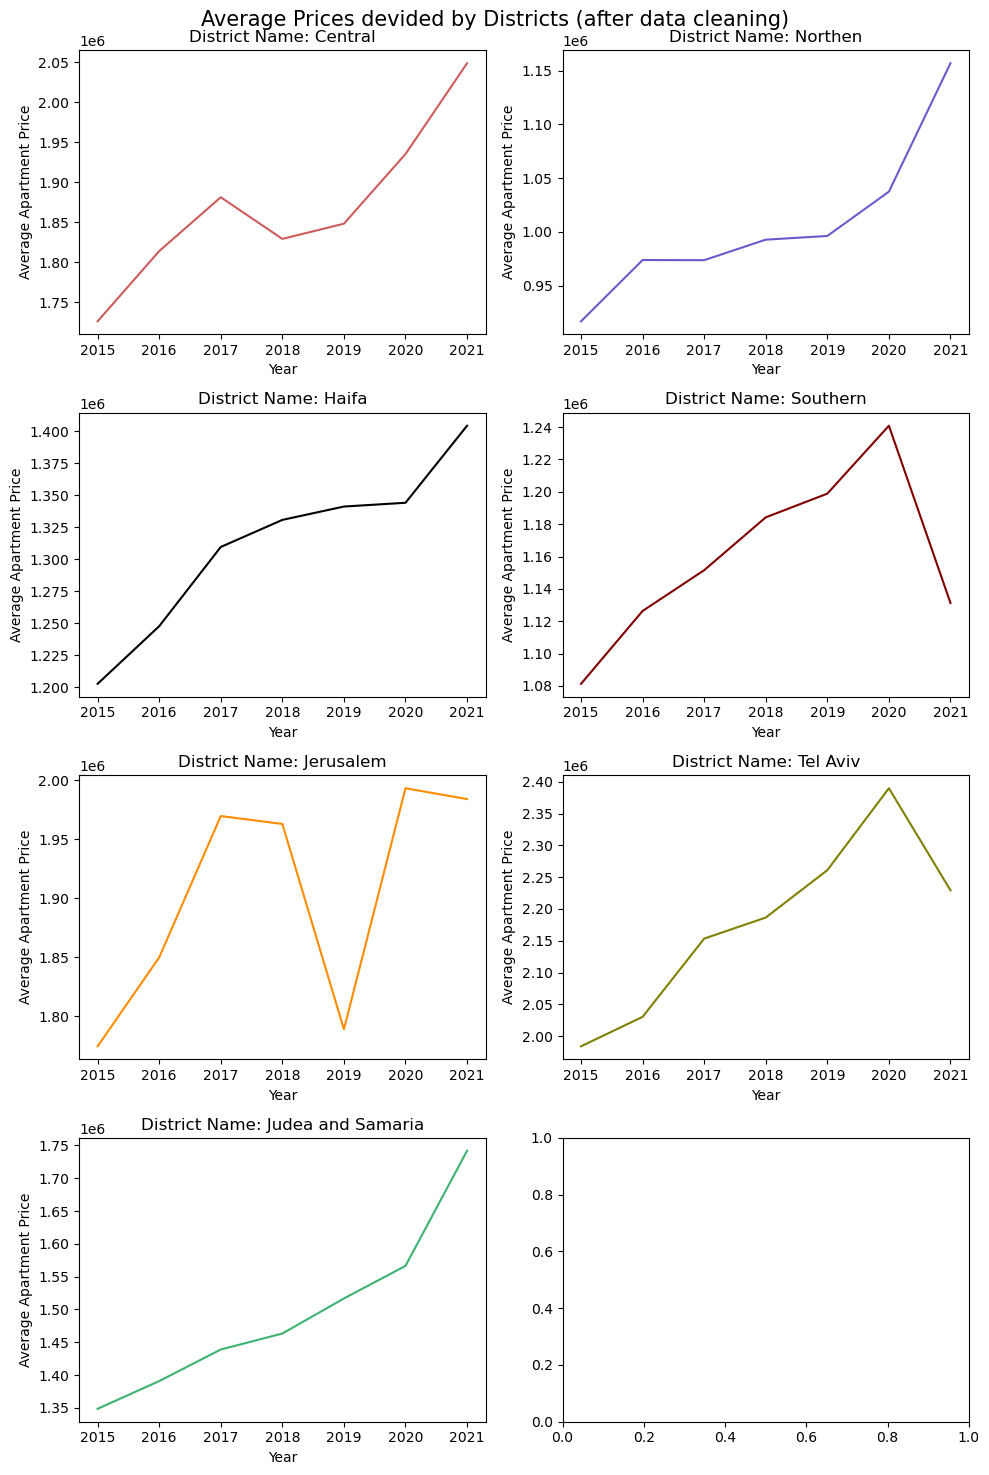

In [60]:
groups = df.groupby(["year", "district"])
avg_price = groups["price"].mean().reset_index()
groups = avg_price.groupby("district")
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,15))
fig.suptitle("Average Prices devided by Districts (after data cleaning)", size = 15)

for i, (name, group) in enumerate(groups):
    ax = axes[i%4][int(i/4)]
    ax.plot(group["year"], group["price"], color = colors[i])
    ax.set_title("District Name: {}".format(name))
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Apartment Price")

plt.tight_layout()
plt.show()

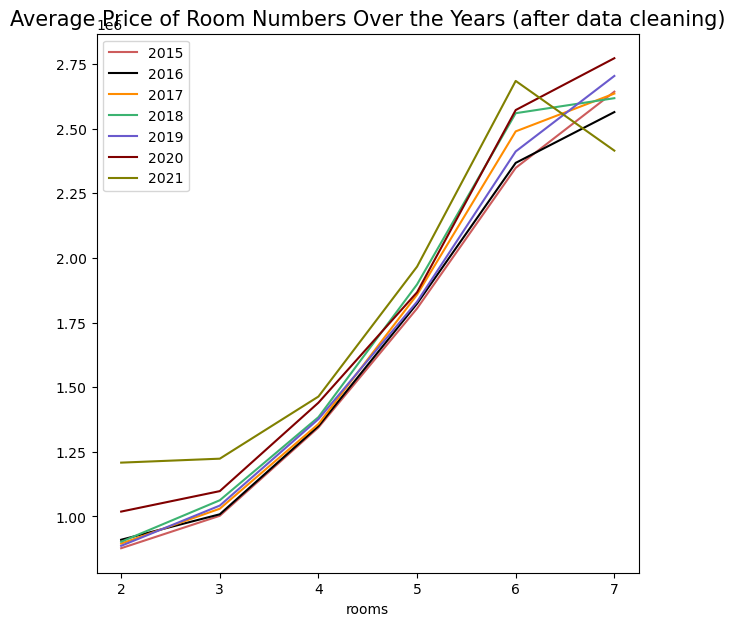

In [61]:
for i in range(len(yearslist)):
    df[df["year"] == yearslist[i]].groupby(["rooms"])['price'].mean().plot(kind = "line",legend=True, label = str(yearslist[i]) , color = colors[i], figsize = (7,7))
    
    plt.title("Average Price of Room Numbers Over the Years (after data cleaning)", size = 15)

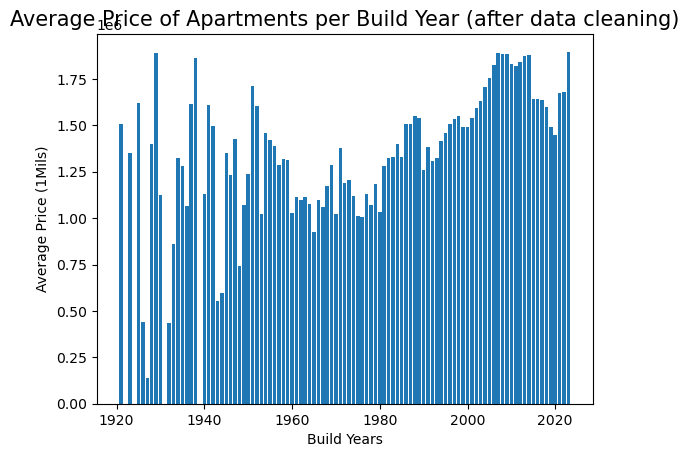

In [62]:
avg_price = df.groupby("build_year")["price"].mean().reset_index()
plt.bar(x=avg_price["build_year"], height =avg_price["price"])
plt.xlabel("Build Years")
plt.ylabel("Average Price (1Mils)")
plt.title("Average Price of Apartments per Build Year (after data cleaning)", size = 15)
plt.show()

## Models

### get_dummies:

In [28]:
df_dummies = df.copy()

In [29]:
df_dummies_all = pd.get_dummies(df_dummies,columns = ["city", "prop_type", "district"],
                                prefix = ["city", "prop_type", "district"])

In [30]:
df_dummies_all.loc[(df_dummies_all["floor"].isnull()),"floor"]= -1
df_dummies_all.loc[(df_dummies_all["parkings"].isnull()),"parkings"]= -1


In [31]:
df_dummies_all

,address,rooms,space,floor,price,price_per_sqm,build_year,parkings,month,year,...,prop_type_קוטג' חד משפחתי,prop_type_קוטג' טורי,prop_type_קומבינציה,district_Central,district_Haifa,district_Jerusalem,district_Judea and Samaria,district_Northen,district_Southern,district_Tel Aviv
0,רמת מוצא 27,5,134,1.0,3675000,27425.0,2000,1.0,1,2021,...,1,0,0,0,0,1,0,0,0,0
1,המבוא 9,2,72,3.0,1961800,27247.0,1960,0.0,1,2021,...,0,0,0,0,0,0,0,0,0,1
4,אור עקיבא 3,5,120,8.0,1665000,13875.0,2017,2.0,1,2021,...,0,0,0,0,1,0,0,0,0,0
5,אופקים - ללא רחוב 34,5,187,1.0,1850000,9893.0,2019,0.0,1,2021,...,1,0,0,0,0,0,0,0,1,0
6,זבוטינסקי 6,3,70,2.0,1445000,20642.0,1960,0.0,1,2021,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440687,הירשפלד 11,4,87,2.0,1500000,17241.0,1974,-1.0,7,2015,...,0,0,0,1,0,0,0,0,0,0
440688,פקיעין 6,4,113,4.0,1100000,9734.0,1998,-1.0,7,2015,...,0,0,0,0,0,0,0,0,1,0
440689,מגידו 8,4,78,2.0,960000,12307.0,2002,-1.0,7,2015,...,0,0,0,0,0,0,0,0,1,0
440690,שפירא אברהם 5,3,61,4.0,810000,13278.0,1971,-1.0,7,2015,...,0,0,0,0,0,0,0,0,1,0


In [32]:
X_train_dummies, X_test_dummies, y_train_dummies, y_test_dummies = split_to_train_and_test(df_dummies_all, "price", 0.2, 42)

In [33]:
trained_model = linear_model.LinearRegression().fit(X_train_dummies , y_train_dummies)
predicted_vals = trained_model.predict(X_test_dummies)
evaluate_value = r2_score(y_test_dummies , predicted_vals)
evaluate_value

0.8669175400354084





### LabelEncoder:

In [160]:
df_encoded_all = df.copy()
for col in ("city", "prop_type", "district"):
    df_encoded_all[col] = sklearn.preprocessing.LabelEncoder().fit_transform(df_encoded_all[col])

In [161]:
df_encoded_all.loc[(df_encoded_all["floor"].isnull()),"floor"]= -1
df_encoded_all.loc[(df_encoded_all["parkings"].isnull()),"parkings"]= -1

In [162]:
df_encoded_all

,city,address,rooms,space,floor,price,price_per_sqm,build_year,prop_type,parkings,month,year,has_yard,district
0,381,רמת מוצא 27,5,134,1.0,3675000,27425.0,2000,7,1.0,1,2021,1,2
1,200,המבוא 9,2,72,3.0,1961800,27247.0,1960,2,0.0,1,2021,0,6
4,29,אור עקיבא 3,5,120,8.0,1665000,13875.0,2017,2,2.0,1,2021,0,1
5,26,אופקים - ללא רחוב 34,5,187,1.0,1850000,9893.0,2019,7,0.0,1,2021,1,5
6,299,זבוטינסקי 6,3,70,2.0,1445000,20642.0,1960,2,0.0,1,2021,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440687,793,הירשפלד 11,4,87,2.0,1500000,17241.0,1974,2,-1.0,7,2015,0,0
440688,89,פקיעין 6,4,113,4.0,1100000,9734.0,1998,2,-1.0,7,2015,0,5
440689,89,מגידו 8,4,78,2.0,960000,12307.0,2002,2,-1.0,7,2015,0,5
440690,83,שפירא אברהם 5,3,61,4.0,810000,13278.0,1971,2,-1.0,7,2015,0,5


In [163]:
X_train_encoded, X_test_encoded, y_train_encoded, y_test_encoded = split_to_train_and_test(df_encoded_all, "price", 0.2, 42)
trained_model = linear_model.LinearRegression().fit(X_train_encoded , y_train_encoded)
predicted_vals = trained_model.predict(X_test_encoded)
evaluate_value = r2_score(y_test_encoded , predicted_vals)
evaluate_value

0.8582532039629407

### KNN:

In [145]:

    k = 5
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_dummies, y_train_dummies)
    y_pred=clf.predict(X_test_dummies)
    print("k used:\n", k)
    print(metrics.confusion_matrix(y_true = y_test_dummies, y_pred = y_pred))
    print('Accuracy = ', metrics.accuracy_score(y_true = y_test_dummies, y_pred = y_pred))
    print("-----------------------------------------------------------------------------------------")

C:\Users\bonik\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


k used:
 5
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Accuracy =  0.33005116323969497
-----------------------------------------------------------------------------------------


In [204]:
    k = 30
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train_encoded, y_train_encoded)
    y_pred=clf.predict(X_test_encoded)
    print("k used:\n", k)
    print(metrics.confusion_matrix(y_true = y_test_encoded, y_pred = y_pred))
    print('Accuracy = ', metrics.accuracy_score(y_true = y_test_encoded, y_pred = y_pred))
    print("-----------------------------------------------------------------------------------------")

C:\Users\matan\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


k used:
 30
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Accuracy =  0.07491070566657013
-----------------------------------------------------------------------------------------


# Conclusion

we can see that the linear regression model has very high R^2 score on our data when using label encoding or get_dummies on categorical columns, meaning you can predict pretty accuretly the price of an apartment based on it's different parameters.
other models did not give a high enough score to be considered good with our data.